# K-nearest Neighbors

Ejemplo de clasificación con KNN con sklearn.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import set_config
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, PredefinedSplit

## Datos

Usamos el dataset `penguins` de seaborn creado por [Allison Horst](https://github.com/allisonhorst/palmerpenguins#about-the-data).

In [2]:
df = sns.load_dataset("penguins")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   bill_length_mm     342 non-null    float64
 3   bill_depth_mm      342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                333 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


Por simplicidad, eliminamos los registros con datos faltantes.

In [4]:
df = df.dropna() 

In [5]:
df['species'].value_counts()

Adelie       146
Gentoo       119
Chinstrap     68
Name: species, dtype: int64

Separamos los datos en features y target.

In [6]:
X = df.drop(columns=['species'])
y = df['species']

Particionamos los datos en training y validation.

>**Importante**: estamos asumiendo que previamente hicimos una partición en train y test. Es decir, la partición final se ve así:

<img src="train_val_test.png">

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=33)

## Modelo

Sugerimos ver estos ejemplos de sklearn:

* [ejemplo 1](https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html#column-transformer-with-mixed-types)
* [ejemplo 2](https://scikit-learn.org/stable/common_pitfalls.html)

### Ajuste

In [8]:
X_train.head()

,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
313,Biscoe,49.5,16.1,224.0,5650.0,MALE
236,Biscoe,42.0,13.5,210.0,4150.0,FEMALE
284,Biscoe,45.8,14.2,219.0,4700.0,FEMALE
22,Biscoe,35.9,19.2,189.0,3800.0,FEMALE
140,Dream,40.2,17.1,193.0,3400.0,FEMALE


In [9]:
X_train["island"].value_counts()

Biscoe       118
Dream         93
Torgersen     38
Name: island, dtype: int64

In [10]:
X_train["sex"].value_counts()

MALE      133
FEMALE    116
Name: sex, dtype: int64

In [11]:
all_features = X.columns.tolist()

categorical_features = [c for c in all_features if X_train[c].dtype == 'object']

numeric_features = [c for c in all_features if X_train[c].dtype != 'object']

print(categorical_features)
print(numeric_features)
print(all_features)

['island', 'sex']
['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']
['island', 'bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g', 'sex']


In [12]:
# tratamiento diferencial para distintas variables

preprocessor = ColumnTransformer([
    # (name, transformer, columns)
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ("num", "passthrough", numeric_features),
], remainder="passthrough")

    # un transformer puede ser un pipeline!

In [13]:
pipe = Pipeline([
    ("preprocessor", preprocessor), 
    ("scaler", MinMaxScaler()),
    ("clf", KNeighborsClassifier(n_neighbors=5, weights='uniform', metric='manhattan')),
])

In [14]:
set_config(display="diagram")
pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['island', 'sex']),
                                                 ('num', 'passthrough',
                                                  ['bill_length_mm',
                                                   'bill_depth_mm',
                                                   'flipper_length_mm',
                                                   'body_mass_g'])])),
                ('scaler', MinMaxScaler()),
                ('clf', KNeighborsClassifier(metric='manhattan'))])

In [15]:
set_config(display="text")
_ = pipe.fit(X_train, y_train)

In [35]:
pipe.named_steps.scaler.data_min_

array([   0. ,    0. ,    0. ,    0. ,    0. ,   33.1,   13.1,  172. ,
       2700. ])

In [38]:
pipe[:-1].get_feature_names_out() 

array(['cat__island_Biscoe', 'cat__island_Dream', 'cat__island_Torgersen',
       'cat__sex_FEMALE', 'cat__sex_MALE', 'num__bill_length_mm',
       'num__bill_depth_mm', 'num__flipper_length_mm', 'num__body_mass_g'],
      dtype=object)

In [17]:
preprocessor.named_transformers_.cat.categories_

[array(['Biscoe', 'Dream', 'Torgersen'], dtype=object),
 array(['FEMALE', 'MALE'], dtype=object)]

In [18]:
pipe[:-1].transform(X_val)

array([[ 0.        ,  1.        ,  0.        ,  0.        ,  1.        ,
         0.6       ,  0.77380952,  0.6779661 ,  0.44444444],
       [ 1.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         0.45283019,  0.1547619 ,  0.6440678 ,  0.47222222],
       [ 0.        ,  0.        ,  1.        ,  1.        ,  0.        ,
         0.24150943,  0.51190476,  0.23728814,  0.30555556],
       [ 1.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         0.54339623,  0.10714286,  0.6779661 ,  0.60416667],
       [ 1.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         0.50943396,  0.13095238,  0.6440678 ,  0.59722222],
       [ 0.        ,  0.        ,  1.        ,  1.        ,  0.        ,
         0.10566038,  0.41666667,  0.30508475,  0.09722222],
       [ 1.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.4490566 ,  0.27380952,  0.81355932,  0.65277778],
       [ 0.        ,  1.        ,  0.        ,  0.        ,  1

### Predict

In [19]:
y_val_pred = pipe.predict(X_val)

In [39]:
print(y_val_pred[:5])
print(y_val[:5])


['Chinstrap' 'Gentoo' 'Adelie' 'Gentoo' 'Gentoo']
199    Chinstrap
272       Gentoo
1         Adelie
308       Gentoo
270       Gentoo
Name: species, dtype: object


In [21]:
accuracy_score(y_val, y_val_pred)

1.0

In [22]:
print(confusion_matrix(y_val, y_val_pred))

[[31  0  0]
 [ 0 18  0]
 [ 0  0 35]]


In [23]:
X_train.head()

,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
313,Biscoe,49.5,16.1,224.0,5650.0,MALE
236,Biscoe,42.0,13.5,210.0,4150.0,FEMALE
284,Biscoe,45.8,14.2,219.0,4700.0,FEMALE
22,Biscoe,35.9,19.2,189.0,3800.0,FEMALE
140,Dream,40.2,17.1,193.0,3400.0,FEMALE


### Ajuste de hiperparámetros

_Grid search_ de hiperparámetros del modelo. Usamos un único corte train-validation.

In [24]:
pipe.named_steps.preprocessor.get_params()

{'n_jobs': None,
 'remainder': 'drop',
 'sparse_threshold': 0.3,
 'transformer_weights': None,
 'transformers': [('cat',
   OneHotEncoder(handle_unknown='ignore'),
   ['island', 'sex']),
  ('num',
   'passthrough',
   ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g'])],
 'verbose': False,
 'verbose_feature_names_out': True,
 'cat': OneHotEncoder(handle_unknown='ignore'),
 'num': 'passthrough',
 'cat__categories': 'auto',
 'cat__drop': None,
 'cat__dtype': numpy.float64,
 'cat__handle_unknown': 'ignore',
 'cat__sparse': True}

In [25]:
param_grid = {
    "clf__n_neighbors": range(1, 15, 2),
    "clf__metric": ["manhattan", "euclidean"],
    "clf__weights": ["uniform", "distance"]
}

In [26]:
split_index = [-1 if x in X_train.index else 0 for x in X.index]
pds = PredefinedSplit(test_fold=split_index)

In [27]:
grid_search = GridSearchCV(pipe, cv=pds, param_grid=param_grid, verbose=10)

In [28]:
_ = grid_search.fit(X, y)

Fitting 1 folds for each of 28 candidates, totalling 28 fits
[CV 1/1; 1/28] START clf__metric=manhattan, clf__n_neighbors=1, clf__weights=uniform
[CV 1/1; 1/28] END clf__metric=manhattan, clf__n_neighbors=1, clf__weights=uniform;, score=0.988 total time=   0.0s
[CV 1/1; 2/28] START clf__metric=manhattan, clf__n_neighbors=1, clf__weights=distance
[CV 1/1; 2/28] END clf__metric=manhattan, clf__n_neighbors=1, clf__weights=distance;, score=0.988 total time=   0.0s
[CV 1/1; 3/28] START clf__metric=manhattan, clf__n_neighbors=3, clf__weights=uniform
[CV 1/1; 3/28] END clf__metric=manhattan, clf__n_neighbors=3, clf__weights=uniform;, score=1.000 total time=   0.0s
[CV 1/1; 4/28] START clf__metric=manhattan, clf__n_neighbors=3, clf__weights=distance
[CV 1/1; 4/28] END clf__metric=manhattan, clf__n_neighbors=3, clf__weights=distance;, score=1.000 total time=   0.0s
[CV 1/1; 5/28] START clf__metric=manhattan, clf__n_neighbors=5, clf__weights=uniform
[CV 1/1; 5/28] END clf__metric=manhattan, clf_

In [29]:
# por que hay 28 lineas?

In [30]:
print(grid_search.best_params_)
print(grid_search.best_score_)

{'clf__metric': 'manhattan', 'clf__n_neighbors': 3, 'clf__weights': 'uniform'}
1.0


In [31]:
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results = cv_results.sort_values("mean_test_score", ascending=False)
cv_results.head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__metric,param_clf__n_neighbors,param_clf__weights,params,split0_test_score,mean_test_score,std_test_score,rank_test_score
27,0.004987,0.0,0.003989,0.0,euclidean,13,distance,"{'clf__metric': 'euclidean', 'clf__n_neighbors...",1.0,1.0,0.0,1
22,0.005017,0.0,0.004988,0.0,euclidean,9,uniform,"{'clf__metric': 'euclidean', 'clf__n_neighbors...",1.0,1.0,0.0,1
20,0.004986,0.0,0.005020,0.0,euclidean,7,uniform,"{'clf__metric': 'euclidean', 'clf__n_neighbors...",1.0,1.0,0.0,1
19,0.003991,0.0,0.003988,0.0,euclidean,5,distance,"{'clf__metric': 'euclidean', 'clf__n_neighbors...",1.0,1.0,0.0,1
18,0.004986,0.0,0.004986,0.0,euclidean,5,uniform,"{'clf__metric': 'euclidean', 'clf__n_neighbors...",1.0,1.0,0.0,1


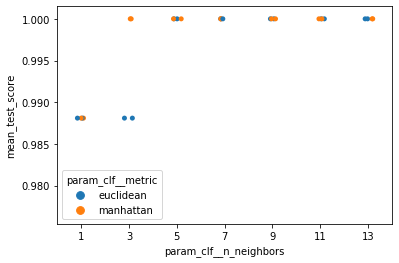

In [32]:
sns.stripplot(
    x="param_clf__n_neighbors", y="mean_test_score", hue="param_clf__metric", 
    data=cv_results)
    # strip agrega jitter
plt.show()

----------------------------------

## Bonus

>_Caching_ para reducir el tiempo de cómputo
>
>Ver: https://scikit-learn.org/stable/auto_examples/neighbors/plot_caching_nearest_neighbors.html